In [1]:
# import the necessary packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [41]:
#ap = argparse.ArgumentParser()

#ap.add_argument('-d', '--dataset', required=True, help='Path to input dataset')
#ap.add_argument('-p', '--plot', type=str, default='plot.png', help='Path to output loss/accuracy plot')
#ap.add_argument('-m', '--model', type=str, default='mask_detector.model', help='path to output face mask detector model')
#args = vars(ap.parse_args())

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args['dataset'])) # paths.list_images is from  imutils
print(imagePaths)

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [24]:
imagePaths = list(paths.list_images('./dataset/')) # paths.list_images is from  imutils
#imagepaths contient list vers tous les fichiers dans dataset dossier
#['./dataset/without_mask/augmented_image_141.jpg', './dataset/without_mask/augmented_image_140.jpg', ......']

data = []
labels = []

for imagePath in imagePaths:
    #Récup le nom de la label class "without_mask" a partir du nom de dossier
    label = imagePath.split(os.path.sep)[-2] #De base -2, . (=0) dataset (=1) without_mask (=2)

    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)



In [25]:
data = np.array(data, dtype='float32')

In [16]:
data

[array([[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        ...,
 
        [[1.        , 0.99215686, 1.        ],
         [1.        , 1.        , 0.98431

In [27]:
lb = LabelBinarizer()
labels =lb.fit_transform(labels)
labels = to_categorical(labels)

In [43]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

'''
https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29

To use the pretrained weights we have to set the argument weights to imagenet. 
The default value is also set to imagenet. 
But if we want to train the model from scratch, 
we can set the weights argument to None. 
This will initialize the weights randomly in the network.

We can remove the default classifier and attach our own classifier in the pretrained model. 
To exclude the default classifier we have to set argument include_top to false.

'''
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
    keras.layers.trainable = False

print("[INFO] compiling model..")
opt = Adam(lr=INIT_LR, decay=INIT_LR/ EPOCHS) # decay or schedule dictate how the learning rates change over time, reduce
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model..
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 201s 6s/step - loss: 0.4859 - accuracy: 0.8008 - val_loss: 0.0300 - val_accuracy: 0.9964
Epoch 2/20
34/34 [==============================] - 188s 6s/step - loss: 0.0510 - accuracy: 0.9887 - val_loss: 0.0231 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 214s 6s/step - loss: 0.0134 - accuracy: 0.9991 - val_loss: 0.0220 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 238s 7s/step - loss: 0.0102 - accuracy: 0.9988 - val_loss: 0.0228 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 189s 6s/step - loss: 0.0160 - accuracy: 0.9971 - val_loss: 0.0277 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 203s 6s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0334 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 167s 5s/step - loss: 0.0036 - accuracy: 1.0000 - val_

In [44]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
model.save_weights("weights_model.h5")

In [ ]:
# later...

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
-Utiliser openCV avec un model pour reconnaitre mask ou non sur image

-Mettre sur kaggle avec le dataset ?

-Améliorer avec le dataset a 3 classes et annotations

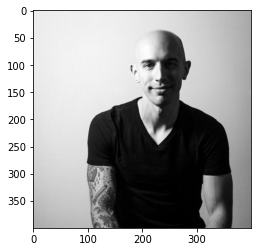

1.3609057e-09
1.0


In [ ]:
#!/usr/bin/env python3

import cv2
import numpy as np
import matplotlib.pyplot as plt

#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml') 

#face_cascade.load('haarcascade_frontalface_default.xml')

# Opening image
img = cv2.imread("./examples/example_02.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.subplot(1, 1, 1)
plt.imshow(img_rgb)
plt.show()

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

#face = roi_color    
#face = img_to_array(face)
#face = preprocess_input(face)
#face = np.expand_dims(face, axis=0)
#print(face.shape)
#face = cv2.resize(face, (28, 28))
# pass the face through the model to determine if the face
# has a mask or not

'''
face = cv2.resize(roi_color,(224,224),3)  # resize
face = np.array(face).astype(np.float32)/255.0  # scaling
face = np.expand_dims(face, axis=0)  # expand dimension
(mask, withoutMask) = model.predict(face)[0]
print(mask)
print(withoutMask)
#image = cv2.resize(image, dimensions, cv2.INTER_AREA)




# determine the class label and color we'll use to draw
# the bounding box and text
label = "Mask" if mask > withoutMask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
# include the probability in the label
label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
# display the label and bounding box rectangle on the output
# frame
cv2.putText(img, label, (10,50 - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2.rectangle(img, (10, 50), (30, 100), color, 2)'''

cv2.imshow('img',img)
k = cv2.waitKey(0)
if k == 27:         # wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'): # wait for 's' key to save and exit
    cv2.imwrite('new_img.png',img)
    cv2.destroyAllWindows()

In [9]:
#!/usr/bin/env python3

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


#dnn > haarcascade
#https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml') 

#face_cascade.load('haarcascade_frontalface_default.xml')

# Opening image
#img = cv2.imread("./examples/example_02.png")
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#plt.subplot(1, 1, 1)
#plt.imshow(img_rgb)
#plt.show()

        
modelFile = "./model/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "./model/deploy.proto.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

img = cv2.imread("./examples/macron.jpg")
h, w = img.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
(300, 300), (104.0, 117.0, 123.0))

#passing blob through the network to detect and pridiction
net.setInput(blob)
faces = net.forward()

# loop over the detections
for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        print(confidence)

        if confidence > 0.5:
            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2)

            face = img[startY:endY,startX:endX]
            face = cv2.resize(face, (224,224))  # resize
            face = np.array(face).astype(np.float32)/255.0  # scaling
            face = np.expand_dims(face, axis=0)  # expand dimension
            model = load_model('model.h5')
            (mask, withoutMask) = model.predict(face)[0]
            #image = cv2.resize(image, dimensions, cv2.INTER_AREA)
            # determine the class label and color we'll use to draw
            # the bounding box and text
            if mask > withoutMask:
                label = "Mask"
            else:
                label = "No Mask"
            
            if label == "Mask":
                color = (0, 255, 0) 
            else:
                color = (0, 0, 255)
                # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(img, label, (startX,startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)

#face = roi_color    
#face = img_to_array(face)
#face = preprocess_input(face)
#face = np.expand_dims(face, axis=0)
#print(face.shape)
#face = cv2.resize(face, (28, 28))
# pass the face through the model to determine if the face
# has a mask or not



cv2.imshow('img',img)
k = cv2.waitKey(0)
if k == 27:         # wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'): # wait for 's' key to save and exit
    cv2.imwrite('new_img.png',img)
    cv2.destroyAllWindows()

0.9999596
0.12813452
0.11867534
0.114794895
0.10494979
0.10024823
0.09148542
0.09078926
0.090440474
0.088333525
0.086452566
0.08608418
0.08534096
0.08445401
0.083995596
0.08341575
0.08307664
0.08297408
0.08291529
0.08259724
0.081608444
0.08136961
0.08136383
0.08131693
0.08115489
0.08106356
0.08075458
0.080587834
0.080403484
0.080336
0.080307424
0.08019623
0.07973809
0.07939478
0.07935938
0.07893639
0.07888292
0.07835739
0.078073196
0.07788332
0.077875115
0.07759481
0.07758413
0.07754474
0.07749199
0.0774624
0.077324204
0.077173576
0.07709845
0.0770851
0.076961756
0.076760165
0.076689996
0.076534785
0.07650523
0.07606446
0.076014705
0.07597959
0.07577189
0.07574111
0.07573921
0.07558042
0.07551946
0.07545051
0.07539102
0.07538248
0.07537879
0.07520121
0.07503209
0.075004905
0.07483585
0.07483084
0.074812315
0.07476365
0.074674614
0.07466098
0.07461816
0.07458831
0.07445682
0.07429544
0.074113004
0.07407813
0.07395719
0.07394447
0.07386713
0.0738538
0.07378727
0.07373218
0.07372593
0.073

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [4]:
img.shape

NameError: name 'img' is not defined

In [ ]:
#!/usr/bin/env python3

import cv2
import numpy as np
import matplotlib.pyplot as plt

#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml') 

#face_cascade.load('haarcascade_frontalface_default.xml')

# Opening image
img = cv2.imread("./examples/face_test.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#plt.subplot(1, 1, 1)
#plt.imshow(img_rgb)
#plt.show()

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

#face = roi_color    
#face = img_to_array(face)
#face = preprocess_input(face)
#face = np.expand_dims(face, axis=0)
#print(face.shape)
#face = cv2.resize(face, (28, 28))
# pass the face through the model to determine if the face
# has a mask or not

'''
face = cv2.resize(roi_color,(224,224),3)  # resize
face = np.array(face).astype(np.float32)/255.0  # scaling
face = np.expand_dims(face, axis=0)  # expand dimension
(mask, withoutMask) = model.predict(face)[0]
print(mask)
print(withoutMask)
#image = cv2.resize(image, dimensions, cv2.INTER_AREA)




# determine the class label and color we'll use to draw
# the bounding box and text
label = "Mask" if mask > withoutMask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
# include the probability in the label
label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
# display the label and bounding box rectangle on the output
# frame
cv2.putText(img, label, (10,50 - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2.rectangle(img, (10, 50), (30, 100), color, 2)'''

cv2.imshow('img',img)
k = cv2.waitKey(0)
if k == 27:         # wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'): # wait for 's' key to save and exit
    cv2.imwrite('new_img.png',img)
    cv2.destroyAllWindows()